## Libraries

In [250]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# About this Sprint​ ​
### The purpose of this Sprint
<li> Know the practical flow of machine learning
<li> Complete a model with high generalization performance </li>
    
### How to learn
    
After making it possible to perform careful verification, we will proceed with model creation with high generalization performance, referring to the solution of others.

## Machine learning flow

Using Kaggle's Home Credit Default Risk competition as a starting point, we will learn the practical flow of machine learning. In particular, we will aim to complete a model with a high generalisation performance and appropriate validation.​ ​

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)

## Problem 1: Cross Validation
In the pre-learning period, the verification data was divided first, and the index value was calculated for that, and verification was performed. (**Holdout method**) However, the accuracy varies depending on the division method; in practice **Cross Validation**. This is a method of performing splitting multiple times and performing learning and verification for each. KFold class is provided in scikit-learn for splitting multiple times.


Create and execute code that Validation baseline model created in the pre-learning period assignment

[sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

### Training Data

In [252]:
data = pd.read_csv('application_train.csv')
data.shape

(307511, 122)

### Test Data

In [253]:
test_data = pd.read_csv('application_test.csv')
test_data.shape

(48744, 121)

### Target Column

In [254]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

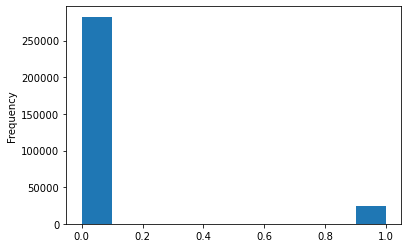

In [255]:
data['TARGET'].astype(int).plot.hist();

In [256]:
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Missing value

In [257]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [258]:
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [259]:
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding categorical data

In [260]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            test_data[col] = le.transform(test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [261]:
print('Training Features shape: ', data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [262]:
data_train = pd.get_dummies(data.drop(['TARGET'], axis=1))
data_test = pd.get_dummies(test_data)
print('Training Features shape: ', data_train.shape)
print('Testing Features shape: ', data_test.shape)
train_labels = data['TARGET']
data_train['TARGET'] = train_labels

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

In [265]:
train_labels = data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
data_train, data_test = data_train.align(data_test, join = 'inner', axis = 1)

# Add the target back in
data_train['TARGET'] = train_labels

print('Training Features shape: ', data_train.shape)
print('Testing Features shape: ', data_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### Fill in missing values

In [266]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
if 'TARGET' in data_train:
    train = data_train.drop(columns = ['TARGET'])
else:
    train = data_train.copy()

# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(data_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


### Cross Validation using Logistic Regression

In [267]:
#Logistic Regression Model
log_reg = LogisticRegression(C = 0.0001)
#Cross Valition  
cv = KFold(n_splits=10, random_state=1, shuffle=True)
#Data
my_X = train[:,:-1]
my_Y = train[:,-1]
clf = DecisionTreeClassifier()

scores = cross_val_score(log_reg, my_X, my_Y, cv=cv,scoring = 'accuracy',error_score="raise")
print('Accuracy: %.6f (%.6f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.992430 (0.000313)


array([0.99239074, 0.99226041, 0.99226041, 0.99252057, 0.99242301,
       0.99245553, 0.99226041, 0.99330103, 0.99209782, 0.99232545])

### Cross Validation using Random Forest

In [268]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
scores = cross_val_score(rf, my_X, my_Y, cv=cv,scoring = 'accuracy',error_score="raise")
print('Accuracy: %.6f (%.6f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.992430 (0.000313)


array([0.99239074, 0.99226041, 0.99226041, 0.99252057, 0.99242301,
       0.99245553, 0.99226041, 0.99330103, 0.99209782, 0.99232545])

## Problem 2: Grid search
So far, I haven't touched on the classifier parameters and used the default settings. Details of the parameters will be learned in future sprints. As a prerequisite for machine learning, it is necessary to select the optimum parameters according to the situation. Searching for the optimum parameters is called **parameter tuning**. A simple way to automate parameter tuning to some extent is **grid search**.


Please use Scikit-learn's GridSearchCV to create the code for grid search. Then do some parameter tuning on the baseline model. Please refer to the official documentation of the method used to determine which parameters to tune.


[sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


To the GridSearchCV class, give the model, the search range, and the number of divisions for cross Validation as arguments. You don't need to use KFold class if you want to use it as it also includes cross Validation functionality.



In [269]:
from sklearn.model_selection import RandomizedSearchCV

#Grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [3],
    'max_features': [2],
    'min_samples_leaf': [3],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}

In [270]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(my_X, my_Y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3],
                         'max_features': [2], 'min_samples_leaf': [3],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

#### The Best Parameter:
I have run GridSearch on many values but it took a lot of time and memory crash so i only reduce to few parameter and and 2 cross validation for the Grid Search and here is the best parameters

In [272]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 3,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

## Problem 3: Survey from Kaggle Notebooks
Discover and list various ideas from Kaggle's Notebooks.

Some ideas I have found on Kaggle:
<li> Use advance models: Random Forest, Gradient Boosting
<li> Apply advance Feature Engineering: use domain knowledge features(credit_income_percent,annuity_income_percent,credit_term,days_emplyed_percent)

## Problem 4: Creating a model with high generalization performance

Please combine the idea found in Problem 3 and your own idea to create a model with high generalization performance.


As a process, please summarize in a table what you did and how much the cross Validation results changed.

### Domain Knowledge Features

In [273]:
domain_train = data_train.copy()
domain_test = data_test.copy()

In [274]:
domain_train['CREDIT_INCOME_PERCENT'] = domain_train['AMT_CREDIT'] / domain_train['AMT_INCOME_TOTAL']
domain_train['ANNUITY_INCOME_PERCENT'] = domain_train['AMT_ANNUITY'] / domain_train['AMT_INCOME_TOTAL']
domain_train['CREDIT_TERM'] = domain_train['AMT_ANNUITY'] / domain_train['AMT_CREDIT']
domain_train['DAYS_EMPLOYED_PERCENT'] = domain_train['DAYS_EMPLOYED'] / domain_train['DAYS_BIRTH']

In [275]:
domain_test['CREDIT_INCOME_PERCENT'] = domain_test['AMT_CREDIT'] / domain_test['AMT_INCOME_TOTAL']
domain_test['ANNUITY_INCOME_PERCENT'] = domain_test['AMT_ANNUITY'] / domain_test['AMT_INCOME_TOTAL']
domain_test['CREDIT_TERM'] = domain_test['AMT_ANNUITY'] / domain_test['AMT_CREDIT']
domain_test['DAYS_EMPLOYED_PERCENT'] = domain_test['DAYS_EMPLOYED'] / domain_test['DAYS_BIRTH']

### Training with Random Forest

In [189]:
rf.fit(train,train_labels)

RandomForestClassifier(max_depth=2, random_state=0)

### Predict using Random Forest

In [226]:
rf_pred = rf.predict_proba(test)[:,1]
rf_pred.shape

(48744,)

In [198]:
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = rf_pred
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.105535
1,100005,0.082066
2,100013,0.080446
3,100028,0.089807
4,100038,0.077613


In [199]:
#Write to CSV
submit.to_csv('rf_prediction.csv', index = False)

### Predict using Random Forest for Domain Knowledge Features

In [243]:
train.shape

(307511, 242)

In [283]:
train_domain = domain_train.drop(columns = 'TARGET')

domain_features_names = list(train_domain.columns)

# Impute the domainnomial features

domain_features = imputer.fit_transform(train_domain)
domain_features_test = imputer.transform(domain_test)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


In [284]:
predictions.shape

(48744,)

In [280]:
domain_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,1,0,1,0,1,2.007889,0.121978,0.060749,0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,1,0,0,4.790750,0.132217,0.027598,0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,2.000000,0.100000,0.050000,0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,2.316167,0.219900,0.094941,0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,4.222222,0.179963,0.042623,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0,1,0,1,0,0,1.617143,0.174971,0.108198,0.025303
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0,1,0,1,0,0,3.743750,0.166687,0.044524,-17.580890
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,1,0,0,1,0,0,4.429176,0.195941,0.044239,0.529266
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,0,1,0,1,0,1,2.164368,0.118158,0.054592,0.400134


In [279]:
domain_train.shape

(48744, 239)

In [286]:
submit = data_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
# submit
# # Save the submission dataframe
submit.to_csv('rf_domain_knowledge_prediction.csv', index = False)

### Gradient Boosting

In [290]:
import lightgbm as lgb
import gc
from sklearn.metrics import roc_auc_score

In [291]:
def gradientboost(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
submission, fi, metrics = gradientboost(data_train, data_test)

Training Data Shape:  (307511, 238)
Testing Data Shape:  (48744, 238)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755595	valid's binary_logloss: 0.54495
Early stopping, best iteration is:
[309]	train's auc: 0.815791	train's binary_logloss: 0.531059	valid's auc: 0.755755	valid's binary_logloss: 0.55289
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
Early stopping, best iteration is:
[282]	train's auc: 0.811912	train's binary_logloss: 0.53493	valid's auc: 0.758533	valid's binary_logloss: 0.555532
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_loglo

In [292]:
submission

,SK_ID_CURR,TARGET
0,100001,0.275991
1,100005,0.564269
2,100013,0.172737
3,100028,0.301978
4,100038,0.677455
...,...,...
48739,456221,0.232281
48740,456222,0.494844
48741,456223,0.259802
48742,456224,0.420240


In [294]:
submission.to_csv('lbg.csv', index = False)

In [295]:
submission_domain, fi_domain, metrics_domain = gradientboost(domain_train, domain_test)

Training Data Shape:  (307511, 242)
Testing Data Shape:  (48744, 242)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804378	train's binary_logloss: 0.541831	valid's auc: 0.761596	valid's binary_logloss: 0.557466
Early stopping, best iteration is:
[262]	train's auc: 0.814303	train's binary_logloss: 0.531734	valid's auc: 0.762001	valid's binary_logloss: 0.551324
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804064	train's binary_logloss: 0.542335	valid's auc: 0.765642	valid's binary_logloss: 0.55762
Early stopping, best iteration is:
[227]	train's auc: 0.808533	train's binary_logloss: 0.537794	valid's auc: 0.766055	valid's binary_logloss: 0.554817
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.803567	train's binary_logloss: 0.543168	valid's auc: 0.77026	valid's binary_logloss: 0.557961
Early stopping, best iteration is:
[241]	train's auc: 0.810407	train's binary_logloss: 0.536195	

In [297]:
submission_domain
submission_domain.to_csv('lgb_domain_feature.csv', index = False)

## Problem 5: Final model selection
Ultimately, choose a model that says it's good and submit the estimated results to Kaggle to see your score. Please describe what kind of idea you adopted and what the score was

### Public Score Result:
<li> Previous Submission using Logarit Regression: 0.68426 </li>
<li> Random Forest: 0.42773 </li>
<li> Random Forest with Domain Knowledge: 0.69985 </li>
<li> Gradient Boost: 0.74453</li>
<li> Gradient Boost with Domain Knowledge: 0.76053</li>

### Public Score Result:
<li> Previous Submission using Logarit Regression: 0.68426 </li>
<li> Random Forest: 0.43378 </li>
<li> Random Forest with Domain Knowledge: 0.70319 </li>
<li> Gradient Boost: 0.74611 </li>
<li> Gradient Boost with Domain Knowledge: 0.76074</li>

For all the model and paramter i have tried, Gradient Boosting is the best one. With 0.76053 in public and 0.76074 in private. 